In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [11]:
# Load dataset
df = pd.read_csv('../data/data.csv')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

In [13]:
# Overview of data
print(df.shape)
print(df.info())

# Summary statistics
print(df.describe())

(95662, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudRe

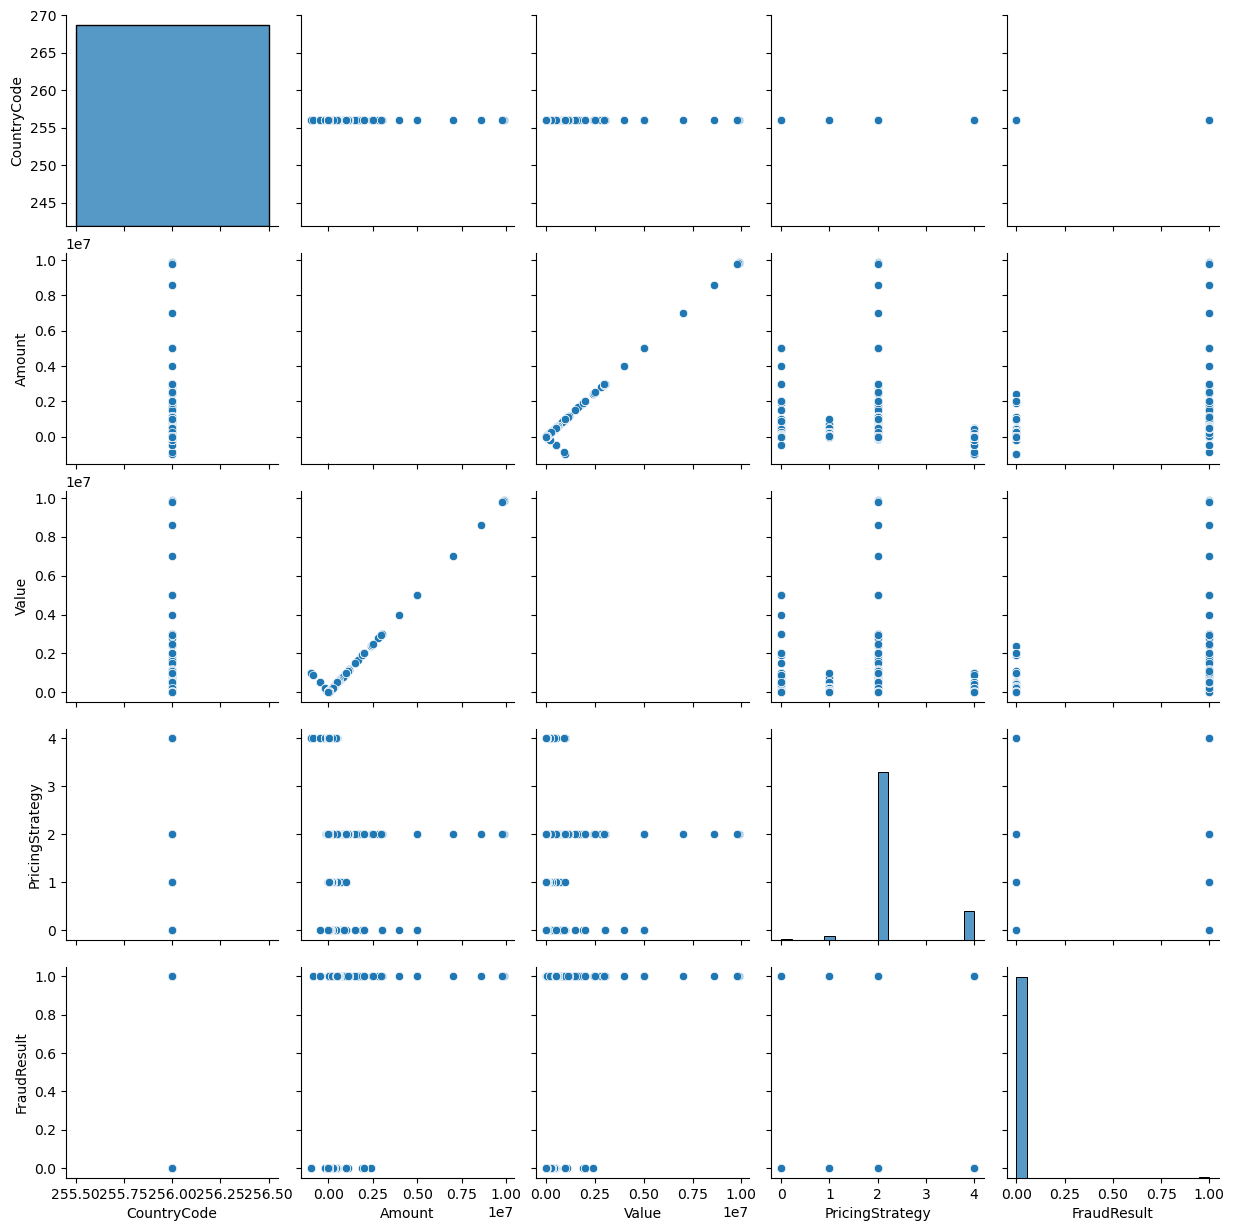

In [14]:
# Visualize relationships
sns.pairplot(df)
plt.show()

In [15]:
# Check for missing values
print(df.isnull().sum())

TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
FraudResult             0
dtype: int64


In [16]:
# Feature Engineering
# Convert transaction date to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionStartTime'])

# Calculate RFMS features
recency = df.groupby('CustomerId').agg(Recency=('TransactionDate', lambda x: (x.max() - x.min()).days))
frequency = df.groupby('CustomerId').agg(Frequency=('TransactionId', 'count'))
monetary = df.groupby('CustomerId').agg(Monetary=('Amount', 'sum'))
size = df.groupby('CustomerId').agg(Size=('Amount', 'mean'))

# Combine RFMS features into one DataFrame
rfms_df = pd.concat([recency, frequency, monetary, size], axis=1)
print(rfms_df.head())

                 Recency  Frequency  Monetary          Size
CustomerId                                                 
CustomerId_1           0          1  -10000.0 -10000.000000
CustomerId_10          0          1  -10000.0 -10000.000000
CustomerId_1001        0          5   20000.0   4000.000000
CustomerId_1002       63         11    4225.0    384.090909
CustomerId_1003        0          6   20000.0   3333.333333


In [17]:
# Classify customers as good or bad based on RFMS scores
rfms_df['RiskScore'] = (
    (rfms_df['Recency'] < rfms_df['Recency'].mean()) &
    (rfms_df['Frequency'] > rfms_df['Frequency'].mean()) &
    (rfms_df['Monetary'] > rfms_df['Monetary'].mean()) &
    (rfms_df['Size'] > rfms_df['Size'].mean())
).astype(int)

rfms_df['RiskLabel'] = rfms_df['RiskScore'].apply(lambda x: 'good' if x == 1 else 'bad')
print(rfms_df[['RiskScore', 'RiskLabel']].head())

                 RiskScore RiskLabel
CustomerId                          
CustomerId_1             0       bad
CustomerId_10            0       bad
CustomerId_1001          0       bad
CustomerId_1002          0       bad
CustomerId_1003          0       bad


In [18]:
# Split data
X = rfms_df[['Recency', 'Frequency', 'Monetary', 'Size']]
y = rfms_df['RiskScore']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
log_reg = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)
gbm = GradientBoostingClassifier().fit(X_train, y_train)

# Evaluate models
print('Logistic Regression AUC:', roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]))
print('Random Forest AUC:', roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
print('Gradient Boosting AUC:', roc_auc_score(y_test, gbm.predict_proba(X_test)[:, 1]))


/opt/miniconda3/envs/10-a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression AUC: nan
Random Forest AUC: nan
Gradient Boosting AUC: nan


/opt/miniconda3/envs/10-a/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/miniconda3/envs/10-a/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/miniconda3/envs/10-a/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [20]:
import pickle

# Save models
with open('../models/log_reg_model.pkl', 'wb') as f:
    pickle.dump(log_reg, f)
with open('../models/rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)
with open('../models/gbm_model.pkl', 'wb') as f:
    pickle.dump(gbm, f)